In [1]:
import os
import cv2
import numpy
import pandas
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
### Constants
DATA_PATH = "./dataset_no_overfitt/train_data" # path to the dataset
LABEL_PATH = './media/labels_no0.csv' # path to the labels csv file
RESULT_PATH = "dataset_no_overfitt" # path to the labels csv file
BATCH_SIZE_VAL = 50 # size of batches during training
STEPS_X_EPOCH = 2000 # number of steps per epoch
N_EPOCHS = 100 # number of epochs for training
IMG_DIM = (32,32,3) # dimensions of the images (height, width, channels)
TEST_DATA = 0.2 # proportion of the data to use for testing (1000 images split will 200)
VAL_DATA = 0.2 # proportion of training data to use for validation (1000 images 20% of remaining 800 will be 160 for validation)

In [ ]:
### Functions
def grayscale(img):
	"""function to convert the image to grayscale"""
	if len(img.shape) == 2: # if image is already grayscale
		return img # return it as is
	else:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
		return img

def equalize(img):
	"""function to equalize the histogram for contrast adjustment"""
	img = img.astype(numpy.uint8) # ensure the image is 8-bit grayscale
	img = cv2.equalizeHist(img) # apply histogram equalization
	return img

def preprocessing(img):
	"""function to preprocess the image"""
	img = grayscale(img) # convert to grayscale
	img = equalize(img) # equalize histogram
	img = img / 255 # normalize pixel values to the range [0, 1] instead of [0, 255]
	return img

def t_sign_model(n_classes):
	"""funtion to define the CNN model"""
	n_kernels = 60 # number of kernels
	kernel_size_5x5 = (5, 5) # size of the kernels (5x5)
	kernel_size_3x3 = (3, 3) # size of the second kernel (3x3)
	pool_size = (2, 2) # size of the pooling window (2x2): reduces img size by half to prevent overfitting
	n_nodes = 500 # number of nodes in the fully connected layer

	# initialize the model
	model = Sequential()

	# First convolutional block (add more conv layers = less features but more accurate)
	model.add((Conv2D(n_kernels, kernel_size_5x5, input_shape=(IMG_DIM[0], IMG_DIM[1], 1), activation='relu')))
	model.add((Conv2D(n_kernels, kernel_size_5x5, activation='relu'))) # 2nd conv layer
	model.add(MaxPooling2D(pool_size=pool_size)) # max pooling layer

	# Second convolutional block
	model.add((Conv2D(n_kernels // 2, kernel_size_3x3, activation='relu'))) # 3rd conv layer with smaller kernel size
	model.add((Conv2D(n_kernels // 2, kernel_size_3x3, activation='relu'))) # 4th conv layer
	model.add(MaxPooling2D(pool_size=pool_size)) # max pooling layer
	model.add(Dropout(0.5)) # dropout layer to prevent overfitting

	# Fully connected layers
	model.add(Flatten()) # flatten the output for the fully connected layer
	model.add(Dense(n_nodes, activation='relu')) # fully connected layer with ReLU activation
	model.add(Dropout(0.5)) # dropout layer for regularization
	model.add(Dense(n_classes, activation='softmax')) # output layer with softmax for multi-class classification

	# compile the model with Adam optimizer and categorical cross-entropy loss
	model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [4]:
# importing of the Images
class_id = 0 # index for classes
images = [] # list for image data
class_labels = [] # list for class labels
classes = os.listdir(DATA_PATH) # list all folders (classes)
labels = pandas.read_csv(LABEL_PATH) # read the labels csv file
n_classes = len(labels) # total number of classes
print("Total Classes Detected:", n_classes)

# test that there are all folders
print("Classes Detected")
for x in range (0, n_classes):
    if os.listdir(DATA_PATH+"/"+str(class_id)): # list images in class folder
        print(DATA_PATH+"/"+str(class_id)) # print class index
    else:
        print("NO <------>" + DATA_PATH+"/"+str(class_id))
    class_id += 1

class_id = 0
# load the images
print("Importing Classes.....")
for x in range (0, n_classes):
    imgs = os.listdir(DATA_PATH+"/"+str(class_id)) # list images in class folder

    for y in imgs: # loop through each image
        # Skip hidden files like .DS_Store
        if y.startswith('.'):
            continue

        cur_img = cv2.imread(DATA_PATH+"/"+str(class_id)+"/"+y) # read image

        # Check if image was loaded successfully
        if cur_img is not None:
            cur_img = cv2.resize(cur_img, (IMG_DIM[0], IMG_DIM[1])) # resize to IMG_DIM
            images.append(cur_img) # add image to the list
            class_labels.append(class_id) # add class label
        else:
            print(f"Failed to load image: {DATA_PATH}/{class_id}/{y}")

    print(class_id, end =" ") # print class index
    class_id += 1
print(" ")

images = numpy.array(images) # convert list of images to numpy array
class_labels = numpy.array(class_labels) # convert list of class labels to numpy array

Total Classes Detected: 37
Classes Detected
./dataset_no_overfitt/train_data/0
./dataset_no_overfitt/train_data/1
./dataset_no_overfitt/train_data/2
./dataset_no_overfitt/train_data/3
./dataset_no_overfitt/train_data/4
./dataset_no_overfitt/train_data/5
./dataset_no_overfitt/train_data/6
./dataset_no_overfitt/train_data/7
./dataset_no_overfitt/train_data/8
./dataset_no_overfitt/train_data/9
./dataset_no_overfitt/train_data/10
./dataset_no_overfitt/train_data/11
./dataset_no_overfitt/train_data/12
./dataset_no_overfitt/train_data/13
./dataset_no_overfitt/train_data/14
./dataset_no_overfitt/train_data/15
./dataset_no_overfitt/train_data/16
./dataset_no_overfitt/train_data/17
./dataset_no_overfitt/train_data/18
./dataset_no_overfitt/train_data/19
./dataset_no_overfitt/train_data/20
./dataset_no_overfitt/train_data/21
./dataset_no_overfitt/train_data/22
./dataset_no_overfitt/train_data/23
./dataset_no_overfitt/train_data/24
./dataset_no_overfitt/train_data/25
./dataset_no_overfitt/train_da

In [5]:
# split Data
    # X_train = array of images to train
    # y_train = corresponding class IDs
    # X_test = array of images to test
    # y_test = corresponding class IDs

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, class_labels, test_size=TEST_DATA)
# further split training data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VAL_DATA)


# print the shapes of the datasets
print("Data Shapes")
print("Train", X_train.shape, y_train.shape) # print training data shape
print("Validation", X_validation.shape, y_validation.shape) # print validation data shape
print("Test", X_test.shape, y_test.shape) # print test data shape

# check if the number of images matches the number of labels for each dataset
print(f"X_train: {X_train.shape[0]}, y_train: {y_train.shape[0]}")
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels in the training set"
print(f"X_validation: {X_validation.shape[0]}, y_validation: {y_validation.shape[0]}")
assert(X_validation.shape[0] == y_validation.shape[0]), "The number of images is not equal to the number of labels in the validation set"
print(f"X_test: {X_test.shape[0]}, y_test: {y_test.shape[0]}")
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels in the test set"

# check if the image dimensions are correct
assert(X_train.shape[1:] == (IMG_DIM)), "The dimensions of the training images are wrong"
assert(X_validation.shape[1:] == (IMG_DIM)), "The dimensions of the validation images are wrong"
assert(X_test.shape[1:] == (IMG_DIM)), "The dimensions of the test images are wrong"

Data Shapes
Train (27116, 32, 32, 3) (27116,)
Validation (6779, 32, 32, 3) (6779,)
Test (8474, 32, 32, 3) (8474,)
X_train: 27116, y_train: 27116
X_validation: 6779, y_validation: 6779
X_test: 8474, y_test: 8474


data shape  (37, 2) <class 'pandas.core.frame.DataFrame'>


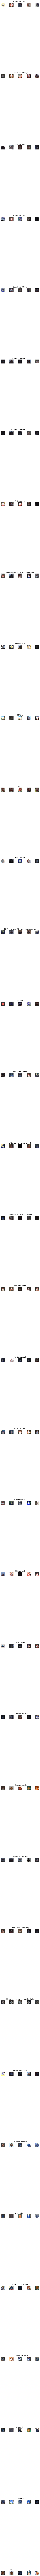

In [6]:
# read the label data from csv file
print("data shape ", labels.shape, type(labels))

# display some sample images from each class

sample_x_class = [] # list for the number of samples per class
n_cols = 5 # number of columns for displaying images
fig, axs = plt.subplots(nrows=n_classes, ncols=n_cols, figsize=(5, 300)) # create subplots
fig.tight_layout() # adjust layout to prevent overlap

# loop through and display images
for i in range(n_cols):
    for j, row in labels.iterrows(): # iterate over rows in the labels
        x_selected = X_train[y_train == j] # select images from the current class
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray")) # display a random image
        axs[j][i].axis("off") # hide axis (for cleaner display)

        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["Name"]) # set title to class label
            sample_x_class.append(len(x_selected)) # add the number of samples for this class

[1331, 1372, 939, 1194, 1150, 826, 800, 860, 751, 1221, 1241, 510, 429, 466, 1231, 1065, 230, 383, 578, 428, 555, 326, 859, 485, 1105, 643, 263, 914, 268, 680, 475, 700, 426, 236, 1388, 304, 484]


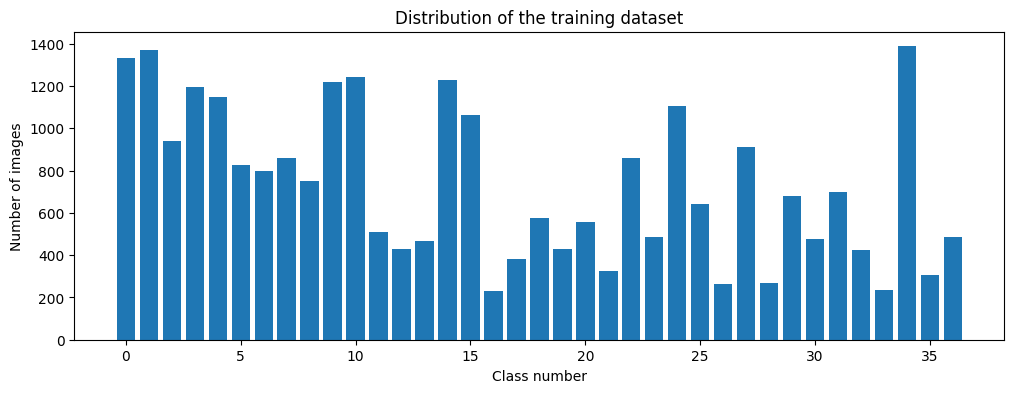

In [7]:
# plot the distribution of training dataset
print(sample_x_class)
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), sample_x_class) # create a bar chart for sample distribution
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [8]:
# preprocess training, validation, and test sets
X_train = numpy.array(list(map(preprocessing, X_train)))
X_validation = numpy.array(list(map(preprocessing, X_validation)))
X_test = numpy.array(list(map(preprocessing, X_test)))

# add a depth of 1 to the images

# reshape the data to add a depth of 1 (grayscale images have only one channel)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

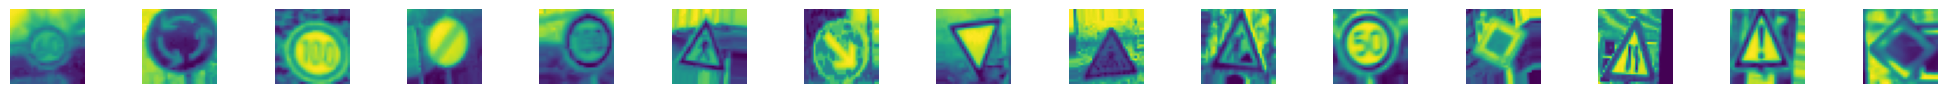

In [9]:
# augmentation of images to make the model more robust

# create an image data generator for augmenting the training data
img_gen = ImageDataGenerator(width_shift_range=0.1, # randomly shift images horizontally by 10%
                            height_shift_range=0.1, # randomly shift images vertically by 10%
                            zoom_range=0.2, # randomly zoom in or out
                            shear_range=0.1, # randomly shear the images
                            rotation_range=10) # randomly rotate images by up to 10 degrees
img_gen.fit(X_train) # fit the generator on the training data
batches = img_gen.flow(X_train, y_train, batch_size=20) # generate augmented images
X_batch, y_batch = next(batches) # get the next batch

# display some augmented images
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(IMG_DIM[0], IMG_DIM[1])) # reshape to 32x32 and display
    axs[i].axis('off') # hide axis (for cleaner display)
plt.show()

# convert labels to one-hot encoded format
y_train = to_categorical(y_train, n_classes)
y_validation = to_categorical(y_validation, n_classes)
y_test = to_categorical(y_test, n_classes)

In [10]:
# Save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
	filepath=RESULT_PATH+".keras", # File path to save the best model
	monitor="val_accuracy", # Metric to monitor
	mode="max", # 'max' since we want the highest validation accuracy
	save_best_only=True, # Save only when validation accuracy improves
	verbose=1 # Print a message when saving the model
)

# Stop training when validation accuracy has stopped improving for 'patience' epochs
early_stopping = EarlyStopping(
	monitor="val_accuracy", # Metric to monitor
	mode="max", # Stop when this metric stops improving
	patience=10, # Number of epochs with no improvement after which training will stop
	restore_best_weights=True, # Restore the weights of the best model at the end of training
	verbose=1 # Print a message when stopping
)

# build and train the model
model = t_sign_model(n_classes)
print(model.summary())

history = model.fit(
    img_gen.flow(X_train, y_train, batch_size=BATCH_SIZE_VAL), # train the model using data augmentation
    steps_per_epoch=STEPS_X_EPOCH, # number of steps per epoch
    epochs=N_EPOCHS, # number of epochs
    validation_data=(X_validation, y_validation), # validation data
	shuffle=True, # shuffle data during training
	callbacks=[early_stopping, checkpoint] # use the early stopping callback
)

/Users/matt/Documents/GitHub/traffic-signs-classification/.env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │        18,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 375,017 (1.43 MB)

 Trainable params: 375,017 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


/Users/matt/Documents/GitHub/traffic-signs-classification/.env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:17 94ms/step - accuracy: 0.1569 - loss: 3.0845

2024-11-18 13:16:35.423775: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.12/3.12.7/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 1: val_accuracy improved from -inf to 0.74908, saving model to dataset_no_overfitt.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 56s 28ms/step - accuracy: 0.2584 - loss: 2.6419 - val_accuracy: 0.7491 - val_loss: 0.8798
Epoch 2/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:27 101ms/step - accuracy: 0.5593 - loss: 1.4233

2024-11-18 13:17:34.598669: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_accuracy improved from 0.74908 to 0.87019, saving model to dataset_no_overfitt.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 59s 30ms/step - accuracy: 0.5880 - loss: 1.3255 - val_accuracy: 0.8702 - val_loss: 0.4365
Epoch 3/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:28 102ms/step - accuracy: 0.7008 - loss: 0.9622
Epoch 3: val_accuracy improved from 0.87019 to 0.92742, saving model to dataset_no_overfitt.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 60s 30ms/step - accuracy: 0.7111 - loss: 0.9281 - val_accuracy: 0.9274 - val_loss: 0.2800
Epoch 4/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:32 104ms/step - accuracy: 0.7680 - loss: 0.7526

2024-11-18 13:19:35.420616: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_accuracy improved from 0.92742 to 0.93908, saving model to dataset_no_overfitt.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 61s 31ms/step - accuracy: 0.7733 - loss: 0.7301 - val_accuracy: 0.9391 - val_loss: 0.2126
Epoch 5/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:33 105ms/step - accuracy: 0.7931 - loss: 0.6579
Epoch 5: val_accuracy improved from 0.93908 to 0.95162, saving model to dataset_no_overfitt.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - accuracy: 0.8036 - loss: 0.6249 - val_accuracy: 0.9516 - val_loss: 0.1661
Epoch 6/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:40 110ms/step - accuracy: 0.8296 - loss: 0.5472
Epoch 6: val_accuracy did not improve from 0.95162
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 65s 32ms/step - accuracy: 0.8306 - loss: 0.5405 - val_accuracy: 0.9512 - val_loss: 0.1598
Epoch 7/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:42 111ms/step - accuracy: 0.8502 - loss: 0.4755
Epoch 7: val_accuracy improved from 0.95162 to 0.96312, saving model to dataset_no_overfitt.keras
2000/2000 ━━

2024-11-18 13:23:52.846491: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_accuracy improved from 0.96312 to 0.96946, saving model to dataset_no_overfitt.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 66s 33ms/step - accuracy: 0.8619 - loss: 0.4461 - val_accuracy: 0.9695 - val_loss: 0.1059
Epoch 9/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:41 111ms/step - accuracy: 0.8702 - loss: 0.4179
Epoch 9: val_accuracy did not improve from 0.96946
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 65s 32ms/step - accuracy: 0.8731 - loss: 0.4054 - val_accuracy: 0.9608 - val_loss: 0.1278
Epoch 10/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:42 112ms/step - accuracy: 0.8814 - loss: 0.3928
Epoch 10: val_accuracy did not improve from 0.96946
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 65s 33ms/step - accuracy: 0.8810 - loss: 0.3901 - val_accuracy: 0.9686 - val_loss: 0.1117
Epoch 11/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:43 112ms/step - accuracy: 0.8857 - loss: 0.3675
Epoch 11: val_accuracy improved from 0.96946 to 0.97610, saving model to dataset_no_overfitt.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 66s 33ms/step - accuracy

2024-11-18 13:32:36.222433: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 16: val_accuracy improved from 0.97876 to 0.98156, saving model to dataset_no_overfitt.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 65s 33ms/step - accuracy: 0.9110 - loss: 0.2892 - val_accuracy: 0.9816 - val_loss: 0.0638
Epoch 17/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:40 110ms/step - accuracy: 0.9163 - loss: 0.2748
Epoch 17: val_accuracy did not improve from 0.98156
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - accuracy: 0.9165 - loss: 0.2726 - val_accuracy: 0.9768 - val_loss: 0.0867
Epoch 18/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:40 110ms/step - accuracy: 0.9143 - loss: 0.2840
Epoch 18: val_accuracy improved from 0.98156 to 0.98274, saving model to dataset_no_overfitt.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - accuracy: 0.9159 - loss: 0.2776 - val_accuracy: 0.9827 - val_loss: 0.0652
Epoch 19/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:38 109ms/step - accuracy: 0.9209 - loss: 0.2648
Epoch 19: val_accuracy did not improve from 0.98274
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 63s 32ms/step - accur

2024-11-18 13:49:49.719281: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 32: val_accuracy did not improve from 0.98731
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 65s 32ms/step - accuracy: 0.9391 - loss: 0.2010 - val_accuracy: 0.9826 - val_loss: 0.0575
Epoch 33/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:39 109ms/step - accuracy: 0.9417 - loss: 0.1868
Epoch 33: val_accuracy did not improve from 0.98731
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - accuracy: 0.9434 - loss: 0.1847 - val_accuracy: 0.9855 - val_loss: 0.0440
Epoch 34/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:40 110ms/step - accuracy: 0.9453 - loss: 0.1757
Epoch 34: val_accuracy did not improve from 0.98731
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - accuracy: 0.9440 - loss: 0.1816 - val_accuracy: 0.9841 - val_loss: 0.0531
Epoch 35/100
 543/2000 ━━━━━━━━━━━━━━━━━━━━ 2:38 109ms/step - accuracy: 0.9399 - loss: 0.1908
Epoch 35: val_accuracy did not improve from 0.98731
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - accuracy: 0.9414 - loss: 0.1888 - val_accuracy: 0.9844 - val_loss: 0.0524
Epoch 36/100
 543/2000 ━━

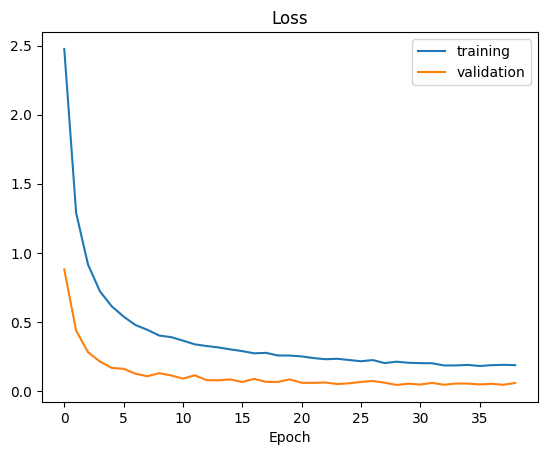

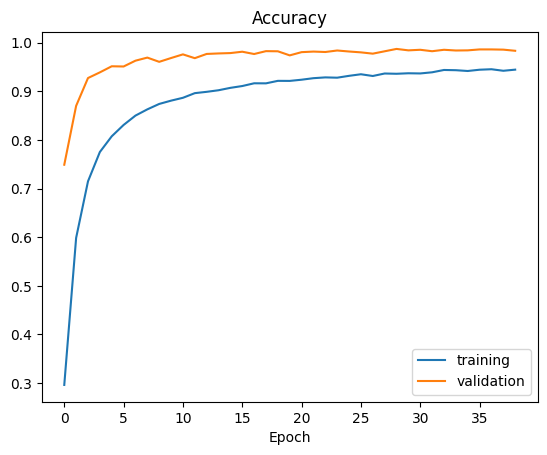

Last Validation Loss: 0.05682860314846039
Last Validation Accuracy: 0.9834783673286438
Test Score: 0.041211724281311035
Test Accuracy: 0.9872551560401917


In [11]:
# plot the training and validation loss
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

# plot the training and validation accuracy
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Get the last values of validation loss
last_val_loss = history.history['val_loss'][-1]
print(f'Last Validation Loss: {last_val_loss}')

# Get the last values of validation accuracy
last_val_accuracy = history.history['val_accuracy'][-1]
print(f'Last Validation Accuracy: {last_val_accuracy}')


# evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0]) # print test loss
print('Test Accuracy:', score[1]) # print test accuracy

# save the trained model
pickle_out = open(RESULT_PATH+".p", "wb")
pickle.dump(model, pickle_out) # serialize and save the model
pickle_out.close()
